In [2]:
input_shape = (3, 256, 256)
num_classes=2

In [ ]:
print(input_shape[1])

In [3]:
import os
import pandas as pd
import numpy as np
import cv2
import random
from tqdm import tqdm
from tqdm.notebook import tqdm as tqdm_notebook
# load libraries
import os
####*IMPORANT*: Have to do this line *before* importing tensorflow
os.environ['PYTHONHASHSEED']=str(1)

import tensorflow as tf
import numpy as np
import random

def reset_random_seeds():
   os.environ['PYTHONHASHSEED']=str(1)
   tf.random.set_seed(1)
   np.random.seed(1)
   random.seed(1)
    
    
reset_random_seeds()

from tensorflow import keras
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras import models
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras import models, layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.layers import Dropout, Flatten, Input, Dense
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras import models, layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.layers import Dropout, Flatten, Input, Dense

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

In [9]:

import os
import torch
from torch.utils.data import Dataset
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
import os
import torch
from torch.utils.data import Dataset
from torchvision.transforms import ToTensor
from PIL import Image

import os
import torch
from torch.utils.data import Dataset
from torchvision.transforms import ToTensor

from PIL import Image

import torchvision.transforms as transforms
import torchvision.models as models
import torch.optim as optim


# Define a transformation for data preprocessing


class CustomDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data = []  # List to store data samples
        self.targets = []  # List to store corresponding labels
        self.class_to_int = {}  # Dictionary to map class labels to integers
        self.int_to_class = {}  # Dictionary to map integers to class labels
        class_index = 0
        
        # Iterate over each class in the directory
        for class_label in os.listdir(data_dir):
            print(class_label)
            class_dir = os.path.join(data_dir, class_label)
            
            # Add class_label to class_to_int dictionary
            self.class_to_int[class_label] = class_index
            self.int_to_class[class_index] = class_label
            class_index += 1
            
            # Iterate over each image in the class directory
            for image_file in os.listdir(class_dir):
                image_path = os.path.join(class_dir, image_file)
                
                # Add the image path and corresponding label to the lists
                self.data.append(image_path)
                self.targets.append(self.class_to_int[class_label])
        
        self.transform = transform

        # Print the shape of data and targets
        print(f"Data shape: {len(self.data)}")
        print(f"Targets shape: {len(self.targets)}")

    def __getitem__(self, index):
        # Retrieve the data sample and its label based on the index
        data_sample = self.data[index]
        target = self.targets[index]
        
        # Load the image using PIL
        image = Image.open(data_sample)
        
        # Resize the image to 32x32
        image = image.resize((input_shape[1], input_shape[2]))
        
        # Apply the data transformation if specified
        if self.transform:
            image = self.transform(image)

        return image, target

    def __len__(self):
        # Return the total number of samples in the dataset
        return len(self.data)


# Set the path to your custom dataset directory
data_dir = '/kaggle/input/breakhis-all-1/BreaKhis_arranged/breast_200/'

# Define the data transformation
transform = ToTensor()  # Use ToTensor() to convert the samples to PyTorch tensors

# Create an instance of your custom dataset
dataset = CustomDataset(data_dir, transform=transform)

# Split the dataset into training, validation, and test sets
train_ratio = 0.7
val_ratio = 0.1
test_ratio = 0.2

# Calculate the sizes of each split
num_samples = len(dataset)
train_size = int(train_ratio * num_samples)
val_size = int(val_ratio * num_samples)
test_size = num_samples - train_size - val_size

# Use the train_test_split function to perform the split
train_data, temp_data = train_test_split(dataset, test_size=(val_size + test_size), random_state=42)
val_data, test_data = train_test_split(temp_data, test_size=test_size, random_state=42)

##################
# Create DataLoader instances for each split
batch_size = 128
trainloader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=2)
valloader = DataLoader(val_data, batch_size=batch_size, shuffle=False, num_workers=2)
testloader = DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=2)

# Print the sizes of each split
print("Train data size:", len(train_data))
print("Validation data size:", len(val_data))
print("Test data size:", len(test_data))



benign
malignant
Data shape: 2013
Targets shape: 2013
Train data size: 1409
Validation data size: 201
Test data size: 403


In [18]:
#with residual connection
num_classes=2
import torch
import torch.nn as nn
import torchvision.models as models

# Define the CBAM module
class CBAM(nn.Module):
    def __init__(self, in_channels):
        super(CBAM, self).__init__()
        self.channel_att = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(in_channels, in_channels // 16, kernel_size=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels // 16, in_channels, kernel_size=1),
            nn.Sigmoid()
        )
        self.spatial_att = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            #nn.MaxPool2d(1),
            nn.Conv2d(in_channels, 1, kernel_size=7, padding=3),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        x_channel_att = self.channel_att(x)
        x_spatial_att = self.spatial_att(x)
        x_att = torch.mul(x_channel_att, x_spatial_att)
        return torch.mul(x, x_att)

#CBAM with residual connection
class ResNet18_CBAM(nn.Module):
    def __init__(self, num_classes):
        super(ResNet18_CBAM, self).__init__()
        self.resnet = models.resnet18(pretrained=True)

        # Disable gradients for all the parameters in the pre-trained ResNet18
        for param in self.resnet.parameters():
            param.requires_grad = False

        # Enable gradients for the last two layers of ResNet18
        for param in self.resnet.layer4.parameters():
            param.requires_grad = False
        for param in self.resnet.layer3.parameters():
            param.requires_grad = True
            
        self.cbam1 = CBAM(64)  # Apply CBAM to the output of layer3
        self.cbam2 = CBAM(128)  # Apply CBAM to the output of layer4
        self.cbam3 = CBAM(256)  # Apply CBAM to the output of layer3
        self.cbam4 = CBAM(512)  # Apply CBAM to the output of layer4

        self.global_avg_pooling = nn.AdaptiveAvgPool2d((1, 1))
        self.fc1 = nn.Linear(960, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.resnet.conv1(x)
        x = self.resnet.bn1(x)
        x = self.resnet.relu(x)
        x = self.resnet.maxpool(x)

        x_res1 = self.resnet.layer1(x)
        x_cbam1 = self.cbam1(x_res1)
        x1 = x_res1 + x_cbam1

        x_res2 = self.resnet.layer2(x1)
        x_cbam2 = self.cbam2(x_res2)
        x2 = x_res2 + x_cbam2

        x_res3 = self.resnet.layer3(x2)
        x_cbam3 = self.cbam3(x_res3)
        x3 = x_res3 + x_cbam3

        x_res4 = self.resnet.layer4(x3)
        x_cbam4 = self.cbam4(x_res4)
        x4 = x_res4 + x_cbam4

        x_cbam1_gap = self.global_avg_pooling(x_cbam1)
        x_cbam2_gap = self.global_avg_pooling(x_cbam2)
        x_cbam3_gap = self.global_avg_pooling(x_cbam3)
        x_cbam4_gap = self.global_avg_pooling(x_cbam4)

        x_cbam_concat = torch.cat([x_cbam1_gap, x_cbam2_gap, x_cbam3_gap, x_cbam4_gap], dim=1)
        x_cbam_concat = x_cbam_concat.view(x_cbam_concat.size(0), -1)
        out = self.fc1(x_cbam_concat)
        out = self.fc2(out)
        return out


import time
# Define your model, loss function, and optimizer
model = ResNet18_CBAM(num_classes)  # Replace `ResNet18_CBAM` with your actual model class
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Set the device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Training loop
num_epochs = 30 # Adjust the number of epochs as needed
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    # Training
    model.train()
    train_loss = 0.0
    correct = 0
    total = 0
    
    start_time = time.time()

    for images, labels in trainloader:
        images = images.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(images)
        
        # Compute loss
        loss = criterion(outputs, labels)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * images.size(0)
        
        # Calculate accuracy
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    # Calculate average training loss and accuracy
    train_loss /= len(train_data)
    train_losses.append(train_loss)
    train_accuracy = correct / total * 100.0
    train_accuracies.append(train_accuracy)
    end_time = time.time()
    test_time = end_time - start_time
    print(f"Training Time: {test_time:.2f} seconds")
    # Validation
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in valloader:
            images = images.to(device)
            labels = labels.to(device)
            
            # Forward pass
            outputs = model(images)
            
            # Compute loss
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
            
            # Calculate accuracy
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    # Calculate average validation loss and accuracy
    val_loss /= len(val_data)
    val_losses.append(val_loss)
    val_accuracy = correct / total * 100.0
    val_accuracies.append(val_accuracy)
    
    # Print epoch statistics
    print(f"Epoch [{epoch+1}/{num_epochs}], "
          f"Train Loss: {train_loss:.4f}, "
          f"Train Accuracy: {train_accuracy:.2f}%, "
          f"Val Loss: {val_loss:.4f}, "
          f"Val Accuracy: {val_accuracy:.2f}%")

# After training, you can evaluate the model on the test data using a similar approach
torch.save(model.state_dict(), "resnet_cbam_weights.pth")
import time

# Evaluate the model on the test set
model.eval()
model = model.to(device)
correct_test = 0
total_test = 0

start_time = time.time()

with torch.no_grad():
    for inputs, labels in testloader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted_test = torch.max(outputs.data, 1)
        total_test += labels.size(0)
        correct_test += (predicted_test == labels).sum().item()

# Calculate test accuracy for the current epoch
test_accuracy = 100 * correct_test / total_test
print(f"Test Accuracy: {test_accuracy:.2f}%")


IndexError: list index out of range

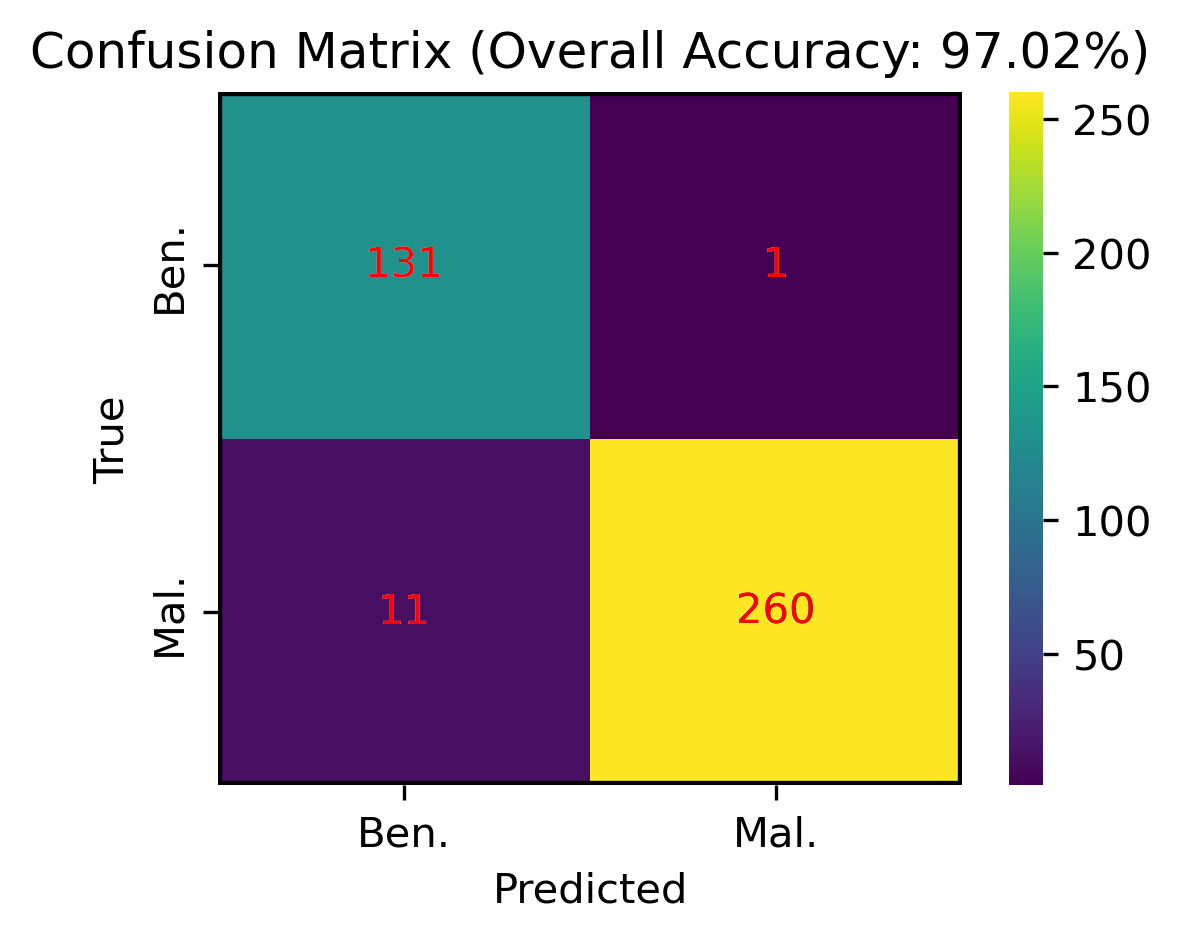

Overall Accuracy: 97.02%


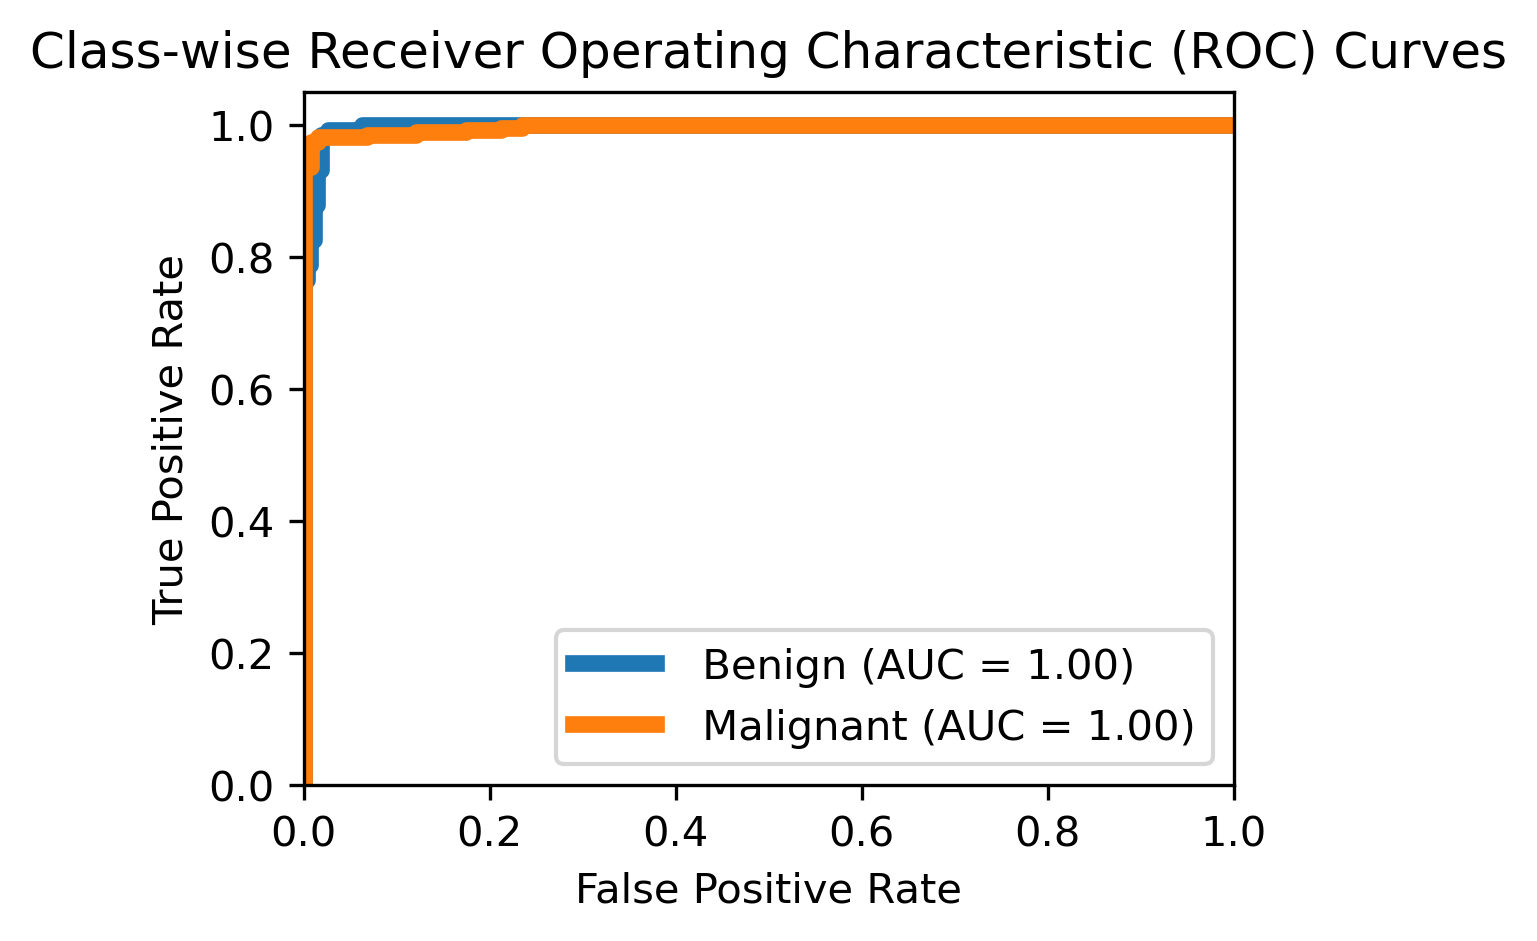

Class-wise Performance Metrics:
              precision    recall  f1-score   support

     Class 0     0.9225    0.9924    0.9562       132
     Class 1     0.9962    0.9594    0.9774       271

    accuracy                         0.9702       403
   macro avg     0.9594    0.9759    0.9668       403
weighted avg     0.9721    0.9702    0.9705       403



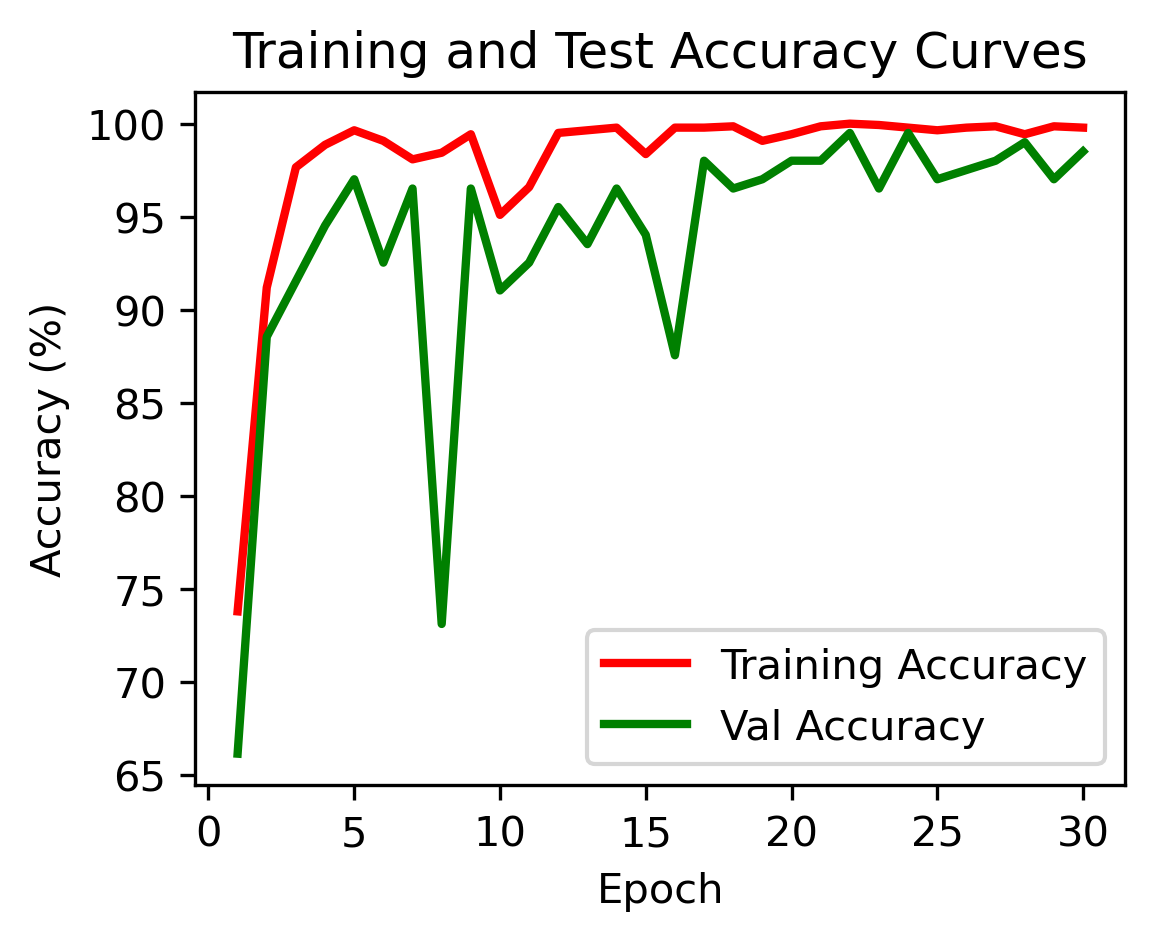

In [9]:

# After training, you can evaluate the model on the test data using a similar approach
model.eval()
all_probs = []
all_labels = []
all_preds = []
with torch.no_grad():
    for images, labels in testloader:
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        
        # Calculate probabilities
        probs = torch.softmax(outputs, dim=1)
        all_probs.append(probs.cpu().numpy())
        
        # Calculate predicted labels
        preds = torch.argmax(outputs, dim=1)
        all_preds.append(preds.cpu().numpy())
        
        all_labels.append(labels.cpu().numpy())

all_probs = np.concatenate(all_probs)
all_labels = np.concatenate(all_labels)
all_preds = np.concatenate(all_preds)

# Plot confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(all_labels, all_preds)
# Calculate overall accuracy from the confusion matrix
overall_accuracy = np.trace(cm) / np.sum(cm) * 100.0

# Print confusion matrix and overall accuracy
class_labels = ["Ben.", "Mal."]  # Replace with your class labels

# Plot confusion matrix
plt.figure(figsize=(4, 3), dpi=300)
sns.heatmap(cm, annot=True, fmt='d', cmap='viridis', annot_kws={"ha": 'center', "va": 'center'})  # Set ha and va parameters
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title(f'Confusion Matrix (Overall Accuracy: {overall_accuracy:.2f}%)')
plt.axhline(y=0, color='k', linewidth=2)  # Add horizontal boundary line
plt.axhline(y=cm.shape[0], color='k', linewidth=2)
plt.axvline(x=0, color='k', linewidth=2)  # Add vertical boundary line
plt.axvline(x=cm.shape[1], color='k', linewidth=2)
plt.xticks(np.arange(len(class_labels)) + 0.5, class_labels, rotation=0)  # Add class labels to x-axis
plt.yticks(np.arange(len(class_labels)) + 0.5, class_labels, rotation=90)   # Add class labels to y-axis

# Add class labels in the center of each cell
for i in range(len(class_labels)):
    for j in range(len(class_labels)):
        plt.text(j + 0.5, i + 0.5, str(cm[i, j]), va='center', ha='center', color='red')


plt.show()

print(f'Overall Accuracy: {overall_accuracy:.2f}%')


# Plot class-wise ROC curves
from sklearn.metrics import roc_curve, auc

# Calculate class-wise ROC curves and AUCs
fpr = {}
tpr = {}
roc_auc = {}

for i in range(num_classes):  # Change `num_classes` to the number of classes in your dataset
    fpr[i], tpr[i], _ = roc_curve(all_labels == i, all_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])


# Plot ROC curves for each class
plt.figure(figsize=(4, 3),dpi=300)
class_labels = ["Benign", "Malignant"]  # Replace with your actual class labels

for i in range(num_classes):  # Change `num_classes` to the number of classes in your dataset
    plt.plot(fpr[i], tpr[i], lw=4, label=f' {class_labels[i]} (AUC = {roc_auc[i]:.2f})')

#plt.plot([0, 1], [0, 1], color='navy', lw=4, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Class-wise Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc='lower right')
plt.show()
from sklearn.metrics import classification_report

# Calculate class-wise precision, recall, F1-score, and support
target_names = [f'Class {i}' for i in range(num_classes)]  # Change `num_classes` to the number of classes in your dataset
class_report = classification_report(all_labels, all_preds, target_names=target_names, digits=4)

# Print the class-wise performance metrics
print("Class-wise Performance Metrics:")
print(class_report)
epochs = range(1, num_epochs + 1)
plt.figure(figsize=(4, 3), dpi=300)  # Set figure size and dpi
plt.plot(epochs, train_accuracies, label='Training Accuracy', linewidth=2, color='red')
plt.plot(epochs, val_accuracies, label='Val Accuracy', linewidth=2, color='green')
plt.title('Training and Test Accuracy Curves')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend(fontsize=10)  # Set legend fontsize
plt.show()


In [ ]:
from sklearn.model_selection import train_test_split

# ... (other code)

# Create an instance of your custom dataset
dataset = CustomDataset(data_dir, transform=transform)

# Get the class labels and their corresponding counts
class_labels = dataset.class_to_int.keys()
class_counts = {class_label: 0 for class_label in class_labels}

# Count the number of samples in each class
for target in dataset.targets:
    class_counts[dataset.int_to_class[target]] += 1

# Print the class names and their corresponding sample counts
for class_label, count in class_counts.items():
    print(f"Class: {class_label}, Number of Samples: {count}")


In [ ]:
# Initialize lists to store the data and labels
x_train = []
y_train = []
x_val = []
y_val = []
x_test = []
y_test = []

# Iterate over the trainloader to get the training data and labels
for images, labels in trainloader:
    x_train.append(images)
    y_train.append(labels)

# Iterate over the valloader to get the validation data and labels
for images, labels in valloader:
    x_val.append(images)
    y_val.append(labels)

# Iterate over the testloader to get the test data and labels
for images, labels in testloader:
    x_test.append(images)
    y_test.append(labels)

# Concatenate the lists to create a single tensor for each dataset
x_train = torch.cat(x_train)
y_train = torch.cat(y_train)
x_val = torch.cat(x_val)
y_val = torch.cat(y_val)
x_test = torch.cat(x_test)
y_test = torch.cat(y_test)

# Print the shapes of the datasets
print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)
print("x_val shape:", x_val.shape)
print("y_val shape:", y_val.shape)
print("x_test shape:", x_test.shape)
print("y_test shape:", y_test.shape)


In [ ]:

#CBAM original
import torch
import torch.nn as nn
import torchvision.models as models

# Define the CBAM module
class CBAM(nn.Module):
    def __init__(self, in_channels):
        super(CBAM, self).__init__()
        self.channel_att = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(in_channels, in_channels // 16, kernel_size=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels // 16, in_channels, kernel_size=1),
            nn.Sigmoid()
        )
        self.spatial_att = nn.Sequential(
            nn.AdaptiveAvgPool2d(1)
            nn.Conv2d(in_channels, 1, kernel_size=7, padding=3),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        x_channel_att = self.channel_att(x)
        print("x_channel_att",x_channel_att.shape)
        x_spatial_att = self.spatial_att(x)
        print("x_spatial_att",x_spatial_att.shape )
        x_att = torch.mul(x_channel_att, x_spatial_att)
        print("x_att",x_att.shape )
        return torch.mul(x, x_att)

# Define the ResNet18 model with CBAM and GAP
class ResNet18_CBAM(nn.Module):
    def __init__(self, num_classes):
        super(ResNet18_CBAM, self).__init__()
        self.resnet = models.resnet18(pretrained=True)
        
        # Disable gradients for all the parameters in the pre-trained ResNet18
        for param in self.resnet.parameters():
            param.requires_grad = False
            
        # Enable gradients for the last two layers of ResNet18
        for param in self.resnet.layer4.parameters():
            param.requires_grad = False
        for param in self.resnet.layer3.parameters():
            param.requires_grad = True
        
        self.cbam1 = CBAM(64)  # Apply CBAM to the output of layer3
        self.cbam2 = CBAM(128)  # Apply CBAM to the output of layer4
        self.cbam3 = CBAM(256)  # Apply CBAM to the output of layer3
        self.cbam4 = CBAM(512)  # Apply CBAM to the output of layer4
        
        self.global_avg_pooling = nn.AdaptiveAvgPool2d((1, 1))
        self.fc1 = nn.Linear(960, 128)
        self.fc2 = nn.Linear(128, num_classes)
        
    def forward(self, x):
        x = self.resnet.conv1(x)
        print("conv1:", x.shape)
        x = self.resnet.bn1(x)
        x = self.resnet.relu(x)
        x = self.resnet.maxpool(x)
        print("maxpool:", x.shape)
        
        x = self.resnet.layer1(x)
        x_cbam1 = self.cbam1(x)
        print("layer1:", x.shape)
        x = self.resnet.layer2(x)
        print("layer2:", x.shape)
        x_cbam2 = self.cbam2(x)  # Apply CBAM to layer2 output
        print("cbam2:", x.shape)
        x = self.resnet.layer3(x)##256
        print("layer3:", x.shape)
        x_cbam3 = self.cbam3(x)  # Apply CBAM to layer3 output
        print(" cbam3:", x.shape)
        x = self.resnet.layer4(x) ##512
        print(" layer4:", x.shape)
        x_cbam4 = self.cbam4(x)
        print(" cbam4:", x_cbam4.shape)
        x_cbam1_gap = self.global_avg_pooling(x_cbam1)
        print(" GAP cbam1:",  x_cbam1_gap.shape)
        x_cbam2_gap = self.global_avg_pooling(x_cbam2)
        print(" GAP cbam2:",  x_cbam2_gap.shape)
        x_cbam3_gap = self.global_avg_pooling(x_cbam3)
        print(" GAP cbam3:",  x_cbam3_gap.shape)
        x_cbam4_gap = self.global_avg_pooling(x_cbam4)
        print(" GAP cbam4:",  x_cbam4_gap.shape)
        
        x_cbam_concat = torch.cat([x_cbam1_gap,x_cbam2_gap,x_cbam3_gap,x_cbam4_gap], dim=1)
        print(" cbam concat:",  x_cbam_concat.shape )
        x_cbam_concat = x_cbam_concat.view(x_cbam_concat.size(0), -1)
        #print("Shape after after view:",  x_cbam_concat.shape )
        out = self.fc1(x_cbam_concat)
        print("out_fc1",out.shape)
        out=self.fc2(out)
        print("out_fc2",out.shape)
        #print("Shape fc:",  out.shape )
        return out



In [4]:

#with residual connection
import torch
import torch.nn as nn
import torchvision.models as models

# Define the CBAM module
class CBAM(nn.Module):
    def __init__(self, in_channels):
        super(CBAM, self).__init__()
        self.channel_att = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(in_channels, in_channels // 16, kernel_size=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels // 16, in_channels, kernel_size=1),
            nn.Sigmoid()
        )
        self.spatial_att = nn.Sequential(
            nn.Conv2d(in_channels, 1, kernel_size=7, padding=3),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        x_channel_att = self.channel_att(x)
        x_spatial_att = self.spatial_att(x)
        x_att = torch.mul(x_channel_att, x_spatial_att)
        return x_spatial_att #torch.mul(x, x_att)

#CBAM with residual connection
class ResNet18_CBAM(nn.Module):
    def __init__(self, num_classes):
        super(ResNet18_CBAM, self).__init__()
        self.resnet = models.resnet18(pretrained=True)

        # Disable gradients for all the parameters in the pre-trained ResNet18
        for param in self.resnet.parameters():
            param.requires_grad = False

        # Enable gradients for the last two layers of ResNet18
        for param in self.resnet.layer4.parameters():
            param.requires_grad = False
        for param in self.resnet.layer3.parameters():
            param.requires_grad = True
            
        self.cbam1 = CBAM(64)  # Apply CBAM to the output of layer3
        self.cbam2 = CBAM(128)  # Apply CBAM to the output of layer4
        self.cbam3 = CBAM(256)  # Apply CBAM to the output of layer3
        self.cbam4 = CBAM(512)  # Apply CBAM to the output of layer4

        self.global_avg_pooling = nn.AdaptiveAvgPool2d((1, 1))
        self.fc1 = nn.Linear(960, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.resnet.conv1(x)
        x = self.resnet.bn1(x)
        x = self.resnet.relu(x)
        x = self.resnet.maxpool(x)

        x_res1 = self.resnet.layer1(x)
        x_cbam1 = self.cbam1(x_res1)
        x1 = x_res1 + x_cbam1

        x_res2 = self.resnet.layer2(x1)
        x_cbam2 = self.cbam2(x_res2)
        x2 = x_res2 + x_cbam2

        x_res3 = self.resnet.layer3(x2)
        x_cbam3 = self.cbam3(x_res3)
        x3 = x_res3 + x_cbam3

        x_res4 = self.resnet.layer4(x3)
        x_cbam4 = self.cbam4(x_res4)
        x4 = x_res4 + x_cbam4

        x_cbam1_gap = self.global_avg_pooling(x1)
        x_cbam2_gap = self.global_avg_pooling(x2)
        x_cbam3_gap = self.global_avg_pooling(x3)
        x_cbam4_gap = self.global_avg_pooling(x4)

        x_cbam_concat = torch.cat([x_cbam1_gap, x_cbam2_gap, x_cbam3_gap, x_cbam4_gap], dim=1)
        x_cbam_concat = x_cbam_concat.view(x_cbam_concat.size(0), -1)
        out = self.fc1(x_cbam_concat)
        out = self.fc2(out)
        return out



In [6]:
# Example usage
input_shape = (3, 256, 256)  # Example input shape for RGB images
num_classes = 2  # Example number of classes
model = ResNet18_CBAM(num_classes)

# Create a random image tensor
image = torch.randn(1, *input_shape)

# Pass the image through the model
output = model(image)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 178MB/s] 


conv1: torch.Size([1, 64, 128, 128])
maxpool: torch.Size([1, 64, 64, 64])
x_channel_att torch.Size([1, 64, 1, 1])


AttributeError: 'SpatialAttention' object has no attribute 'shape'

In [5]:
# Instantiate the ResNet18_CBAM model
#model = ResNet18_CBAM(num_classes)

# Count the number of trainable and non-trainable parameters
num_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
num_non_trainable_params = sum(p.numel() for p in model.parameters() if not p.requires_grad)

# Print the number of trainable and non-trainable parameters
print("Number of trainable parameters: ", num_trainable_params)
print("Number of non-trainable parameters: ", num_non_trainable_params)


Number of trainable parameters:  2314562
Number of non-trainable parameters:  9589800


In [ ]:
!pip install torch-summary

In [ ]:
from torchvision.models import resnet18
from torchsummary import summary

# Instantiate the ResNet18 model from torchvision
model = ResNet18_CBAM(num_classes)

# Print the model summary
summary(model, (3, 256, 256))

# Print the names of trainable and non-trainable layers
for name, param in model.named_parameters():
    if param.requires_grad:
        print("Trainable layer:", name)
    else:
        print("Non-trainable layer:", name)


In [ ]:
''''
#pure renset18
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import torch.optim as optim

# Define a transformation for data preprocessing
transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Instantiate the ResNet18 model for fine-tuning
num_classes = 2
resnet_model = models.resnet18(pretrained=True)

# Freeze all layers except the classification layer
for param in resnet_model.parameters():
    param.requires_grad = False
for param in resnet_model.fc.parameters():
    param.requires_grad = True

# Change the fully connected layer for classification
resnet_model.fc = nn.Linear(512, num_classes)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(resnet_model.fc.parameters(), lr=0.001, momentum=0.9)

# Assuming you have defined trainloader using DataLoader and loaded your data

# Fine-tuning loop
for epoch in range(10):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data

        optimizer.zero_grad()

        outputs = resnet_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        print(f'Epoch {epoch + 1}, Batch {i + 1}, Loss: {running_loss / 100:.3f}')
        running_loss = 0.0

print('Finished fine-tuning')

# Assuming you have defined your test dataset and testloader similarly to how you defined trainloader

# Evaluation loop
resnet_model.eval()  # Set the model to evaluation mode
correct = 0
total = 0
with torch.no_grad():  # No need to compute gradients during evaluation
    for data in testloader:
        images, labels = data

        outputs = resnet_model(images)
        _, predicted = torch.max(outputs.data, 1)  # Get the index of the class with the highest probability
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f'Test Accuracy: {accuracy:.2f}%')


In [ ]:
''''
#pure densennet201
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import torch.optim as optim

# Define a transformation for data preprocessing
transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Instantiate the DenseNet-201 model for fine-tuning
num_classes = 2
densenet_model = models.densenet201(pretrained=True)

# Freeze all layers except the classification layer
for param in densenet_model.parameters():
    param.requires_grad = False
for param in densenet_model.classifier.parameters():
    param.requires_grad = True

# Change the fully connected layer for classification
densenet_model.classifier = nn.Linear(1920, num_classes)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(densenet_model.classifier.parameters(), lr=0.001, momentum=0.9)

# Assuming you have defined trainloader using DataLoader and loaded your data

# Fine-tuning loop
for epoch in range(5):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data

        optimizer.zero_grad()

        outputs = densenet_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        print(f'Epoch {epoch + 1}, Batch {i + 1}, Loss: {running_loss / 100:.3f}')
        running_loss = 0.0

print('Finished fine-tuning')

# Assuming you have defined your test dataset and testloader similarly to how you defined trainloader

# Evaluation loop
densenet_model.eval()  # Set the model to evaluation mode
correct = 0
total = 0
with torch.no_grad():  # No need to compute gradients during evaluation
    for data in testloader:
        images, labels = data

        outputs = densenet_model(images)
        _, predicted = torch.max(outputs.data, 1)  # Get the index of the class with the highest probability
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f'Test Accuracy: {accuracy:.2f}%')


In [ ]:
''''
#pure squeezenet#
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import torch.optim as optim

# Define a transformation for data preprocessing
transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Instantiate the SqueezeNet model for fine-tuning
num_classes = 2
squeezenet_model = models.squeezenet1_0(pretrained=True)

# Modify the classifier layer for binary classification
squeezenet_model.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1, 1), stride=(1, 1))
squeezenet_model.num_classes = num_classes

# Set the classifier layer as trainable and others as non-trainable
for param in squeezenet_model.features.parameters():
    param.requires_grad = False
for param in squeezenet_model.classifier.parameters():
    param.requires_grad = True

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(squeezenet_model.classifier.parameters(), lr=0.001, momentum=0.9)

# Assuming you have defined trainloader using DataLoader and loaded your data

# Fine-tuning loop
for epoch in range(10):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data

        optimizer.zero_grad()

        outputs = squeezenet_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        print(f'Epoch {epoch + 1}, Batch {i + 1}, Loss: {running_loss / 100:.3f}')
        running_loss = 0.0

print('Finished fine-tuning')

# Assuming you have defined your test dataset and testloader similarly to how you defined trainloader

# Evaluation loop
squeezenet_model.eval()  # Set the model to evaluation mode
correct = 0
total = 0
with torch.no_grad():  # No need to compute gradients during evaluation
    for data in testloader:
        images, labels = data

        outputs = squeezenet_model(images)
        _, predicted = torch.max(outputs.data, 1)  # Get the index of the class with the highest probability
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f'Test Accuracy: {accuracy:.2f}%')


In [ ]:
''''
#pure vgg16-81%
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import torch.optim as optim

# Check if a GPU is available and set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define a transformation for data preprocessing
transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Instantiate the VGG16 model for fine-tuning
num_classes = 2
vgg16_model = models.vgg19(pretrained=True)

# Remove the last GAP layer from the classifier
modified_classifier = list(vgg16_model.classifier.children())[:-1]
vgg16_model.classifier = nn.Sequential(*modified_classifier)

# Freeze all layers except the classifier
for param in vgg16_model.features.parameters():
    param.requires_grad = False

# Move the model to the specified device
vgg16_model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(vgg16_model.classifier.parameters(), lr=0.001, momentum=0.9)

# Assuming you have defined trainloader using DataLoader and loaded your data

# Fine-tuning loop
for epoch in range(10):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = vgg16_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        
        print(f'Epoch {epoch + 1}, Batch {i + 1}, Loss: {running_loss / 100:.3f}')
        running_loss = 0.0

print('Finished fine-tuning with VGG16')

# Assuming you have defined your test dataset and testloader similarly to how you defined trainloader

# Evaluation loop
vgg16_model.eval()  # Set the model to evaluation mode
correct = 0
total = 0
with torch.no_grad():  # No need to compute gradients during evaluation
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        
        outputs = vgg16_model(images)
        _, predicted = torch.max(outputs.data, 1)  # Get the index of the class with the highest probability
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f'Test Accuracy: {accuracy:.2f}%')


In [13]:
import time
# Define your model, loss function, and optimizer
model = ResNet18_CBAM(num_classes)  # Replace `ResNet18_CBAM` with your actual model class
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Set the device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Training loop
num_epochs = 10 # Adjust the number of epochs as needed
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    # Training
    model.train()
    train_loss = 0.0
    correct = 0
    total = 0
    
    start_time = time.time()

    for images, labels in trainloader:
        images = images.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(images)
        
        # Compute loss
        loss = criterion(outputs, labels)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * images.size(0)
        
        # Calculate accuracy
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    # Calculate average training loss and accuracy
    train_loss /= len(train_data)
    train_losses.append(train_loss)
    train_accuracy = correct / total * 100.0
    train_accuracies.append(train_accuracy)
    end_time = time.time()
    test_time = end_time - start_time
    print(f"Training Time: {test_time:.2f} seconds")
    # Validation
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in valloader:
            images = images.to(device)
            labels = labels.to(device)
            
            # Forward pass
            outputs = model(images)
            
            # Compute loss
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
            
            # Calculate accuracy
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    # Calculate average validation loss and accuracy
    val_loss /= len(val_data)
    val_losses.append(val_loss)
    val_accuracy = correct / total * 100.0
    val_accuracies.append(val_accuracy)
    
    # Print epoch statistics
    print(f"Epoch [{epoch+1}/{num_epochs}], "
          f"Train Loss: {train_loss:.4f}, "
          f"Train Accuracy: {train_accuracy:.2f}%, "
          f"Val Loss: {val_loss:.4f}, "
          f"Val Accuracy: {val_accuracy:.2f}%")

# After training, you can evaluate the model on the test data using a similar approach
torch.save(model.state_dict(), "resnet_cbam_weights.pth")


conv1: torch.Size([128, 64, 128, 128])
maxpool: torch.Size([128, 64, 64, 64])
x_channel_att torch.Size([128, 64, 1, 1])


RuntimeError: Sizes of tensors must match except in dimension 1. Expected size 1 but got size 64 for tensor number 1 in the list.

In [ ]:
# Instantiate your ResNet18_CBAM model
num_classes = 2  # Change to your number of classes
model = ResNet18_CBAM(num_classes)

# Print the layer names
for name, module in model.named_children():
    print(name)


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


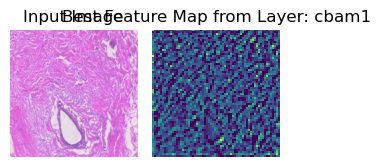

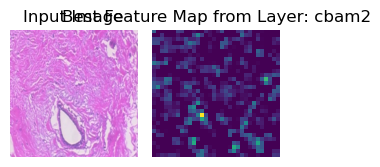

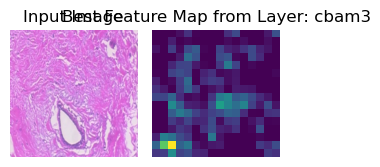

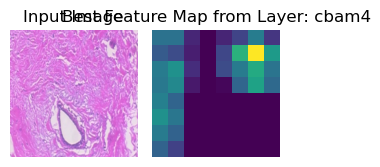

In [11]:
#visualising the best feature maps--->>keep running code to get the possible indexes
import torch
import torchvision.transforms as transforms
import torchvision.models as models
import matplotlib.pyplot as plt

# Instantiate your ResNet18_CBAM model
num_classes = 2  # Change to your number of classes
model = ResNet18_CBAM(num_classes)

# Load the pretrained weights if needed
# model.load_state_dict(torch.load('resnet_cbam_weights.pth'))

# Set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Choose the layers from which you want to visualize feature maps
layer_names = ['cbam1', 'cbam2','cbam3','cbam4']  # Names of the layers you want to visualize

# Hook function to store the layer's output
def hook_fn(module, input, output):
    feature_maps.append(output.cpu().detach().numpy())

# Collect feature maps
feature_maps = []
hooks = []
for layer_name in layer_names:
    layer = getattr(model, layer_name)
    hook = layer.register_forward_hook(hook_fn)
    hooks.append(hook)

# Choose a sample image from the dataset
sample_image, _ = next(iter(trainloader))
sample_image = sample_image.to(device)

# Perform a forward pass to collect feature maps
with torch.no_grad():
    model(sample_image)

# Unregister the hooks
for hook in hooks:
    hook.remove()

# Visualize the input image and best feature map
# Visualize the input image and best feature map
for layer_idx, feature_map in enumerate(feature_maps):
    num_feature_maps = feature_map.shape[1]  # Number of channels
    
    # Find the index of the best feature map based on mean activation
    best_feature_idx = feature_map.mean((0, 1)).argmax()
    
    plt.figure(figsize=(3, 3))  # Adjust the figsize if needed
    
    # Display the input image
    plt.subplot(1, 2, 1)
    plt.imshow(sample_image[0].cpu().numpy().transpose(1, 2, 0))
    plt.title("Input Image")
    plt.axis('off')
    
    # Display the best feature map
    plt.subplot(1, 2, 2)
    
    # Reshape the feature map for visualization
    reshaped_feature_map = feature_map[0, best_feature_idx].squeeze()
    plt.imshow(reshaped_feature_map, cmap='viridis')
    
    plt.title(f'Best Feature Map from Layer: {layer_names[layer_idx]}')
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()





In [ ]:
#visualisation
import torch
import torch.nn.functional as F
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np


# Create an instance of your model
model = ResNet18_CBAM(num_classes)
model.eval()

# Load the saved model weights
model.load_state_dict(torch.load("resnet_cbam_weights.pth"))
model.to(device)
model.eval()

input_image_path = '/kaggle/input/breast-histopathology-images/10253/1/10253_idx5_x601_y301_class1.png'
image = Image.open(input_image_path)

# Preprocess the image
preprocess = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])
input_tensor = preprocess(image)
input_batch = input_tensor.unsqueeze(0)

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
input_batch = input_batch.to(device)

# Forward pass and prediction
output = model(input_batch)
probabilities = F.softmax(output, dim=1)
predicted_class_index = torch.argmax(probabilities, dim=1).item()

# Backward pass and gradient computation
model.zero_grad()
output[:, predicted_class_index].backward()

# Calculate importance weights
importance_weights = torch.mean(model.cbam1.spatial_att[0].weight.grad, dim=(2, 3))
importance_weights = F.relu(importance_weights)  # Only keep positive gradients

# Generate the heatmap
heatmap = torch.zeros_like(model.cbam1.spatial_att[0].weight)
for i, weight in enumerate(importance_weights[0]):
    expanded_weight = weight.unsqueeze(0).unsqueeze(-1).unsqueeze(-1)
    heatmap += expanded_weight * model.cbam1.spatial_att[0].weight

# Normalize the heatmap
heatmap = F.relu(heatmap)
heatmap /= torch.max(heatmap)

# Convert the heatmap to numpy array
heatmap = heatmap.detach().cpu().numpy()

# Visualize the heatmap
# Visualize the heatmap with 'hot' colormap
plt.imshow(heatmap[0, 0], cmap='afmhot')
plt.axis('off')
plt.show()

# Convert the heatmap to numpy array
#heatmap = heatmap.detach().cpu().numpy()

# Apply 'hot' colormap to create the heatmap colors
heatmap_color = plt.get_cmap('afmhot')(heatmap[0, 0])[:, :, :3] * 255
heatmap_color = np.uint8(heatmap_color)

# Convert the heatmap color to PIL Image
heatmap_color = Image.fromarray(heatmap_color)

# Resize the heatmap color to the original image size
heatmap_color = heatmap_color.resize(image.size, resample=Image.BILINEAR)

# Apply heatmap color as an overlay on the image
import matplotlib.colors as mcolors

# Define a custom colormap that transitions from blue to yellow
cmap_yellowish = mcolors.LinearSegmentedColormap.from_list(
    'yellowish', [(0, 'pink'), (1, 'yellow')], N=256
)

# Visualize the original image with the heatmap color overlay
fig, axes = plt.subplots(1, 3, figsize=(10, 5))
axes[0].imshow(image)
axes[0].set_title('Original Image')
axes[0].axis('off')

axes[1].imshow(heatmap_color, cmap=cmap_yellowish)  # Use the custom colormap
axes[1].set_title('Heatmap Color')
axes[1].axis('off')

# Apply heatmap color as an overlay with alpha blending
overlay_color_yellowish = Image.blend(image.convert("RGB"), heatmap_color.convert("RGB"), alpha=0.7)

axes[2].imshow(overlay_color_yellowish)
axes[2].set_title('Heatmap Color Overlay')
axes[2].axis('off')

plt.tight_layout()
plt.show()





In [ ]:
import time

# Evaluate the model on the test set
model.eval()
model = model.to(device)
correct_test = 0
total_test = 0

start_time = time.time()

with torch.no_grad():
    for inputs, labels in testloader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted_test = torch.max(outputs.data, 1)
        total_test += labels.size(0)
        correct_test += (predicted_test == labels).sum().item()

# Calculate test accuracy for the current epoch
test_accuracy = 100 * correct_test / total_test
print(f"Test Accuracy: {test_accuracy:.2f}%")

end_time = time.time()
test_time = end_time - start_time
print(f"Test Time: {test_time:.2f} seconds")

epochs = range(1, num_epochs + 1)
plt.figure(figsize=(4, 3), dpi=300)  # Set figure size and dpi
plt.plot(epochs, train_accuracies, label='Training Accuracy', linewidth=2, color='red')
plt.plot(epochs, val_accuracies, label='Val Accuracy', linewidth=2, color='green')
plt.title('Training and Test Accuracy Curves')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend(fontsize=10)  # Set legend fontsize
plt.show()




In [ ]:
# After training, you can evaluate the model on the test data using a similar approach
model.eval()
all_probs = []
all_labels = []
all_preds = []
with torch.no_grad():
    for images, labels in testloader:
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        
        # Calculate probabilities
        probs = torch.softmax(outputs, dim=1)
        all_probs.append(probs.cpu().numpy())
        
        # Calculate predicted labels
        preds = torch.argmax(outputs, dim=1)
        all_preds.append(preds.cpu().numpy())
        
        all_labels.append(labels.cpu().numpy())

all_probs = np.concatenate(all_probs)
all_labels = np.concatenate(all_labels)
all_preds = np.concatenate(all_preds)

# Plot confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(all_labels, all_preds)
# Calculate overall accuracy from the confusion matrix
overall_accuracy = np.trace(cm) / np.sum(cm) * 100.0

# Print confusion matrix and overall accuracy
class_labels = ["Ben.", "Mal."]  # Replace with your class labels

# Plot confusion matrix
plt.figure(figsize=(4, 3), dpi=300)
sns.heatmap(cm, annot=True, fmt='d', cmap='viridis', annot_kws={"ha": 'center', "va": 'center'})  # Set ha and va parameters
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title(f'Confusion Matrix (Overall Accuracy: {overall_accuracy:.2f}%)')
plt.axhline(y=0, color='k', linewidth=2)  # Add horizontal boundary line
plt.axhline(y=cm.shape[0], color='k', linewidth=2)
plt.axvline(x=0, color='k', linewidth=2)  # Add vertical boundary line
plt.axvline(x=cm.shape[1], color='k', linewidth=2)
plt.xticks(np.arange(len(class_labels)) + 0.5, class_labels, rotation=0)  # Add class labels to x-axis
plt.yticks(np.arange(len(class_labels)) + 0.5, class_labels, rotation=90)   # Add class labels to y-axis

# Add class labels in the center of each cell
for i in range(len(class_labels)):
    for j in range(len(class_labels)):
        plt.text(j + 0.5, i + 0.5, str(cm[i, j]), va='center', ha='center', color='red')


plt.show()

print(f'Overall Accuracy: {overall_accuracy:.2f}%')


# Plot class-wise ROC curves
from sklearn.metrics import roc_curve, auc

# Calculate class-wise ROC curves and AUCs
fpr = {}
tpr = {}
roc_auc = {}

for i in range(num_classes):  # Change `num_classes` to the number of classes in your dataset
    fpr[i], tpr[i], _ = roc_curve(all_labels == i, all_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])


# Plot ROC curves for each class
plt.figure(figsize=(4, 3),dpi=300)
class_labels = ["Benign", "Malignant"]  # Replace with your actual class labels

for i in range(num_classes):  # Change `num_classes` to the number of classes in your dataset
    plt.plot(fpr[i], tpr[i], lw=4, label=f' {class_labels[i]} (AUC = {roc_auc[i]:.2f})')

#plt.plot([0, 1], [0, 1], color='navy', lw=4, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Class-wise Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc='lower right')
plt.show()


In [ ]:
from sklearn.metrics import classification_report

# Calculate class-wise precision, recall, F1-score, and support
target_names = [f'Class {i}' for i in range(num_classes)]  # Change `num_classes` to the number of classes in your dataset
class_report = classification_report(all_labels, all_preds, target_names=target_names, digits=4)

# Print the class-wise performance metrics
print("Class-wise Performance Metrics:")
print(class_report)


In [ ]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
import xgboost as xgb
import lightgbm as lgb

# Assuming you have trained the ResNet18_CBAM model and obtained the trained_model

# Save the trained model
#torch.save(model.state_dict(), 'resnet18_cbam_model.pth')

# Assuming you have the training dataset as train_dataset

# Load the saved ResNet18_CBAM model
#model = ResNet18_CBAM(num_classes)
#model.load_state_dict(torch.load('resnet18_cbam_model.pth'))
model.eval()

# Set the device (CPU or GPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
# Define the transformation for the images
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Extract features from the training set using the trained model
# Assuming you have the training dataset as train_dataset

# Extract features from the training set using the trained model
train_features = []
train_labels = []
for images, labels in trainloader:
    images = images.to(device)
    features = model(images)
    train_features.append(features.detach().cpu().numpy())
    train_labels.append(labels)

train_features = np.concatenate(train_features)
train_labels = np.array(train_labels)

# Extract features from the test set using the trained model
test_features = []
test_labels = []
for images, labels in testloader:
    images = images.to(device)
    features = model(images)
    test_features.append(features.detach().cpu().numpy())
    test_labels.append(labels)

test_features = np.concatenate(test_features)
test_labels = np.array(test_labels)

# Convert train_labels to a flattened numpy array
train_labels = np.concatenate(train_labels)
test_labels = np.concatenate(test_labels)
# Split the data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(train_features, train_labels, test_size=0.2, random_state=42)

# Train XGBoost classifier
xgb_clf = xgb.XGBClassifier()
xgb_clf.fit(X_train, y_train)
xgb_pred = xgb_clf.predict(X_val)
xgb_accuracy = accuracy_score(y_val, xgb_pred)
print(f"XGBoost Accuracy: {xgb_accuracy:.4f}")

# Train Naive Bayes classifier
nb_clf = GaussianNB()
nb_clf.fit(X_train, y_train)
nb_pred = nb_clf.predict(X_val)
nb_accuracy = accuracy_score(y_val, nb_pred)
print(f"Naive Bayes Accuracy: {nb_accuracy:.4f}")

# Train Random Forest classifier
rf_clf = RandomForestClassifier()
rf_clf.fit(X_train, y_train)
rf_pred = rf_clf.predict(X_val)
rf_accuracy = accuracy_score(y_val, rf_pred)
print(f"Random Forest Accuracy: {rf_accuracy:.4f}")

# Train SVM classifier
svm_clf = SVC()
svm_clf.fit(X_train, y_train)
svm_pred = svm_clf.predict(X_val)
svm_accuracy = accuracy_score(y_val, svm_pred)
print(f"SVM Accuracy: {svm_accuracy:.4f}")

# Train LightGBM classifier
lgb_clf = lgb.LGBMClassifier()
lgb_clf.fit(X_train, y_train)
lgb_pred = lgb_clf.predict(X_val)
lgb_accuracy = accuracy_score(y_val, lgb_pred)
print(f"lgb Accuracy: {lgb_accuracy:.4f}")

# Predict using the trained models on the test set
xgb_test_pred = xgb_clf.predict(test_features)
nb_test_pred = nb_clf.predict(test_features)
rf_test_pred = rf_clf.predict(test_features)
svm_test_pred = svm_clf.predict(test_features)
lgb_test_pred = lgb_clf.predict(test_features)

# Calculate accuracy on the test set
xgb_test_accuracy = accuracy_score(test_labels, xgb_test_pred)
nb_test_accuracy = accuracy_score(test_labels, nb_test_pred)
rf_test_accuracy = accuracy_score(test_labels, rf_test_pred)
svm_test_accuracy = accuracy_score(test_labels, svm_test_pred)
lgb_test_accuracy = accuracy_score(test_labels, lgb_test_pred)

# Print the accuracy of each model on the test set
print(f"XGBoost Test Accuracy: {xgb_test_accuracy:.4f}")
print(f"Naive Bayes Test Accuracy: {nb_test_accuracy:.4f}")
print(f"Random Forest Test Accuracy: {rf_test_accuracy:.4f}")
print(f"SVM Test Accuracy: {svm_test_accuracy:.4f}")
print(f"LightGBM Test Accuracy: {lgb_test_accuracy:.4f}")
